In [277]:
import torch
import torch.nn as nn
from PIL import Image
import os
from IPython.display import display
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms

In [278]:
class UNet_Denoise(nn.Module):

    def __init__(self):
        super(UNet_Denoise, self).__init__()

        # Convolution level 1
        self.conv1_1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # C2
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # C3
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # C4
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.conv5_1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)

        # Transposed convolution level 5
        self.transpose4 = nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upconv4_2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.upconv4_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        # T3
        self.transpose3 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upconv3_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upconv3_1 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        # T2
        self.transpose2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upconv2_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.Tconv2_1 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        # T1
        self.transpose1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upconv1_3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.upconv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.upconv1_1 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

        # Skip connections
        self.skip_connection1 = nn.Conv2d(64, 64, kernel_size=1)
        self.skip_connection2 = nn.Conv2d(128, 128, kernel_size=1)
        self.skip_connection3 = nn.Conv2d(256, 256, kernel_size=1)
        self.skip_connection4 = nn.Conv2d(512, 512, kernel_size=1)

    def forward(self, x):
        s1_1 = self.conv1_1(x)
        rel1 = F.relu(s1_1)
        s1_2 = self.conv1_2(rel1)
        rel2 = F.relu(s1_2)
        pooled1 = self.pool1(rel2)

        s2_1 = self.conv2_1(pooled1)
        rel3 = F.relu(s2_1)
        s2_2 = self.conv2_2(rel3)
        rel4 = F.relu(s2_2)
        pooled2 = self.pool2(rel4)

        s3_1 = self.conv3_1(pooled2)
        rel5 = F.relu(s3_1)
        s3_2 = self.conv3_2(rel5)
        rel6 = F.relu(s3_2)
        pooled3 = self.pool3(rel6)

        s4_1 = self.conv4_1(pooled3)
        rel7 = F.relu(s4_1)
        s4_2 = self.conv4_2(rel7)
        rel8 = F.relu(s4_2)
        pooled4 = self.pool4(rel8)

        # bottleneck
        s5_1 = self.conv5_1(pooled4)
        rel9 = F.relu(s5_1)
        s5_2 = self.conv5_2(rel9)
        rel10 = F.relu(s5_2)

        # after bottleneck
        up4 = self.transpose4(rel10)
        skip_con4 = self.skip_connection4(rel8)
        up4 = torch.cat([up4, skip_con4], dim=1)
        upconv4_2 = self.upconv4_2(up4)
        uprel4_2 = F.relu(upconv4_2)
        upconv4_1 = self.upconv4_1(uprel4_2)
        uprel4_1 = F.relu(upconv4_1)

        up3 = self.transpose3(uprel4_1)
        skip_con3 = self.skip_connection3(rel6)
        up3 = torch.cat([up3, skip_con3], dim=1)
        upconv3_2 = self.upconv3_2(up3)
        uprel3_2 = F.relu(upconv3_2)
        upconv3_1 = self.upconv3_1(uprel3_2)
        uprel3_1 = F.relu(upconv3_1)

        up2 = self.transpose2(uprel3_1)
        skip_con2 = self.skip_connection2(rel4)
        up2 = torch.cat([up2, skip_con2], dim=1)
        upconv2_2 = self.upconv2_2(up2)
        uprel2_2 = F.relu(upconv2_2)
        Tconv2_1 = self.Tconv2_1(uprel2_2)
        uprel2_1 = F.relu(Tconv2_1)

        #FIXXX
        up1 = self.transpose1(uprel2_1)
        skip_con1 = self.skip_connection1(rel2)
        up1 = torch.cat([up1, skip_con1], dim=1)
        upconv1_3 = self.upconv1_3(up1)
        uprel1_3 = F.relu(upconv1_3)
        upconv1_2 = self.upconv1_2(uprel1_3)
        uprel1_2 = F.relu(upconv1_2)
        upconv1_1 = self.upconv1_1(uprel1_2)
        output = F.relu(upconv1_1)
        return output


<<<Initial image>>


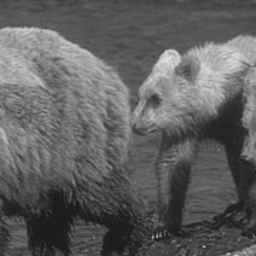

Min value: 0.08627451
Max value: 0.8980392
Width: 256
Height: 256


In [279]:

#setting up the image

image_folder = "Train400"
input_image_path = os.path.join(image_folder, "test_001.png")
input_image = Image.open(input_image_path)
print("<<<Initial image>>")

# resize
resized_image = input_image.resize((256, 256))

# Convert the image to a NumPy array and normalize pixel values
image_array = np.array(resized_image)
image_array = image_array.astype(np.float32) / 255.0

clean_image = Image.fromarray((image_array * 255).astype(np.uint8))
display(clean_image)

# Check the minimum and maximum pixel values
min_value = np.min(image_array)
max_value = np.max(image_array)
width, height = resized_image.size


print("Min value:", min_value)
print("Max value:", max_value)
print("Width:", width)
print("Height:", height)



<<<Noisy normalized image>>


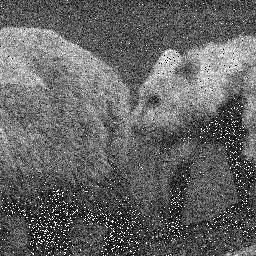

In [280]:

#noisy image generation
mean = 0
variance = 30/255

noise = np.random.normal(mean, variance, image_array.shape)

# Add noise to the image
noisy_image_array = image_array + noise

# Convert the noisy image array back to an image
noisy_image = Image.fromarray((noisy_image_array * 255).astype(np.uint8))

# Display the noisy image

print("<<<Noisy normalized image>>")
display(noisy_image)




noisy image: torch.Size([1, 1, 256, 256])
clean image: torch.Size([1, 1, 256, 256])


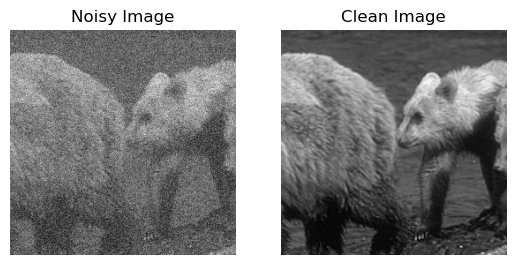

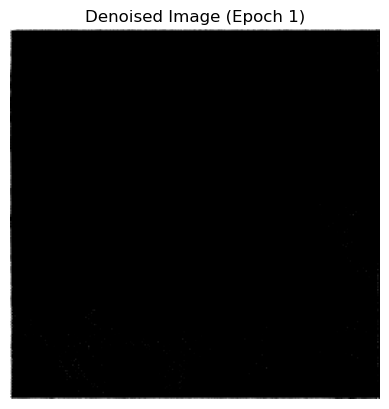

Epoch [1/10], Loss: 0.16626974940299988


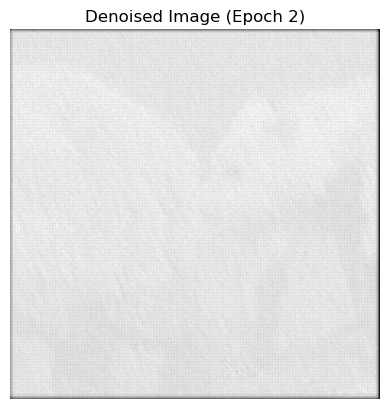

Epoch [2/10], Loss: 0.126694917678833


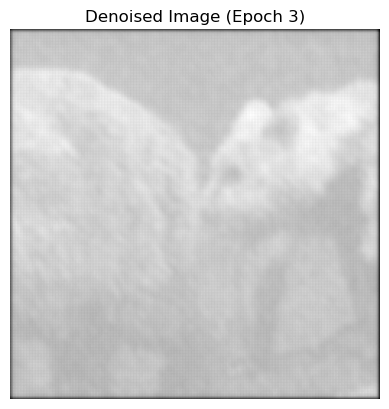

Epoch [3/10], Loss: 0.0762968361377716


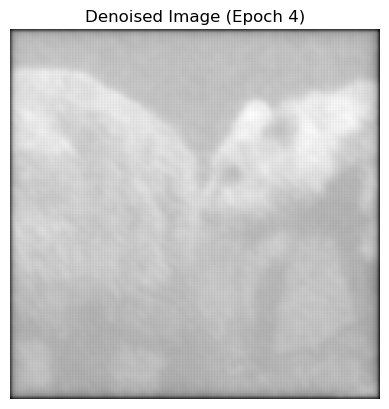

Epoch [4/10], Loss: 0.02164948359131813


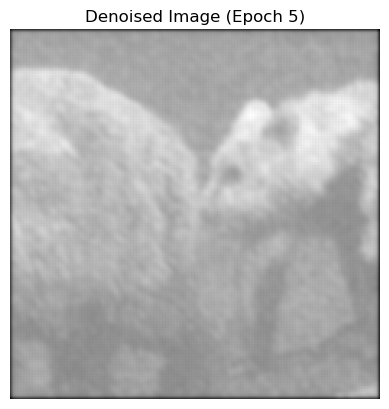

Epoch [5/10], Loss: 0.016106490045785904


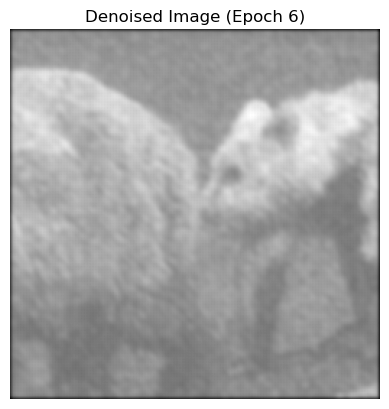

Epoch [6/10], Loss: 0.014025076292455196


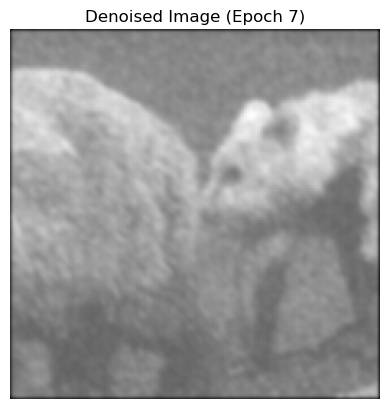

Epoch [7/10], Loss: 0.010446488857269287


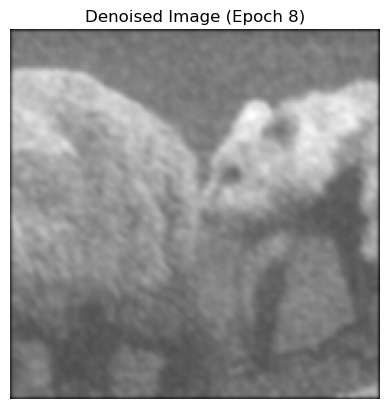

Epoch [8/10], Loss: 0.007791890762746334


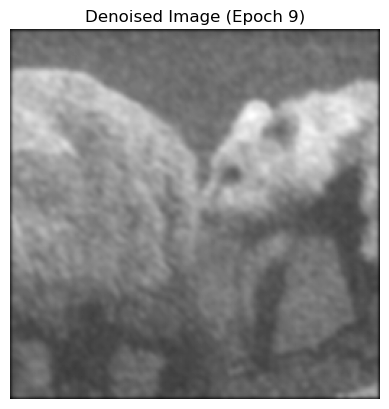

Epoch [9/10], Loss: 0.0068482691422104836


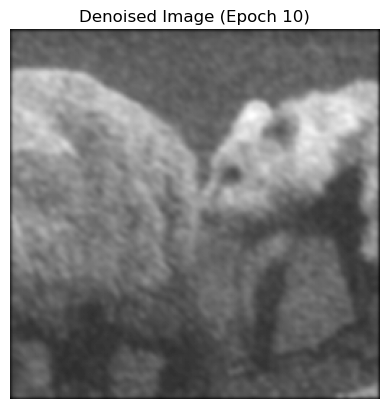

Epoch [10/10], Loss: 0.005448681302368641


In [282]:
model = UNet_Denoise()

# Convert the noisy and clean images to PyTorch tensors and add batch and channel dimensions
noisy_tensor = torch.tensor(noisy_image_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
clean_tensor = torch.tensor(image_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

print("noisy image: " + str(noisy_tensor.shape))
print("clean image: " + str(clean_tensor.shape))

# Display the noisy and clean images
plt.subplot(1, 2, 1)
plt.imshow(noisy_image_array, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_array, cmap='gray')
plt.title('Clean Image')
plt.axis('off')

plt.show()

# Define your loss function and optimizer
loss_fn = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Forward pass
    denoised_output = model(noisy_tensor)
    
    # Compute the loss
    loss = loss_fn(denoised_output, clean_tensor)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Display the denoised image
    denoised_array = denoised_output.squeeze().detach().cpu().numpy()  # Remove batch and channel dimensions, detach from computation graph, and move to CPU
    plt.imshow(denoised_array, cmap='grey')  # Assuming grayscale image
    plt.axis('off')
    plt.title(f'Denoised Image (Epoch {epoch+1})')
    plt.show()

    # Print loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')